In [23]:
import numpy as np 
import scipy 
import librosa
from scipy.io import wavfile

import IPython.display as ipd

import matplotlib.pyplot as plt

In [2]:
audio_file = 'myaudio.wav'
signal, sr = librosa.load(audio_file, sr = None, mono = True)
ipd.Audio(signal, rate = sr)

In [27]:
#inject noise 
def noise(data):
    noise_amp = 0.35 * np.random.uniform() * np.amax(data)
    just_noise_signal = noise_amp * np.random.normal(size = data.shape[0] )
    data = data + just_noise_signal
    return [data,just_noise_signal]

noisy_signal, noise_signal = noise(signal)

In [28]:
#  noise signal WITH speech
ipd.Audio(noisy_signal, rate = sr)

In [29]:
# Just noise signal 
ipd.Audio(noise_signal, rate = sr)

## Noisy Signal

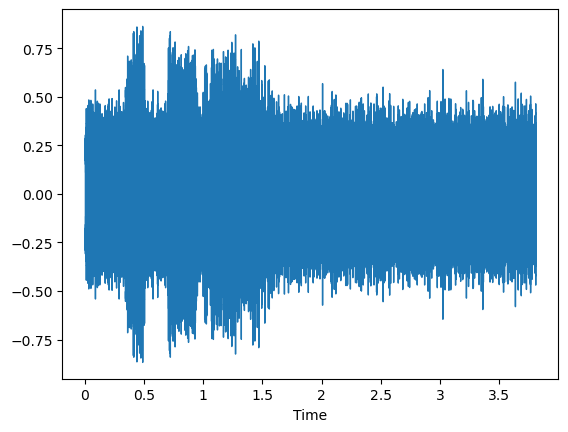

In [30]:
librosa.display.waveshow(noisy_signal)

## Original clean Signal

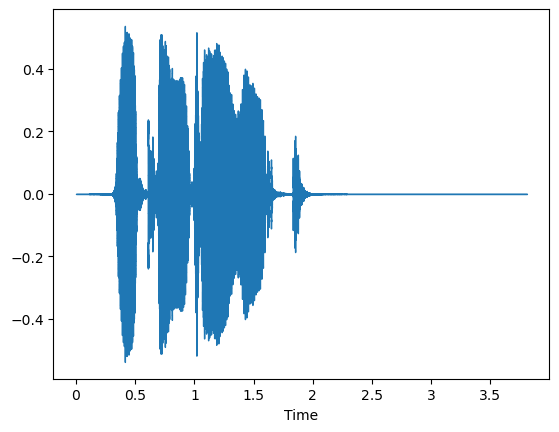

In [31]:
librosa.display.waveshow(signal)

## Noise Signal

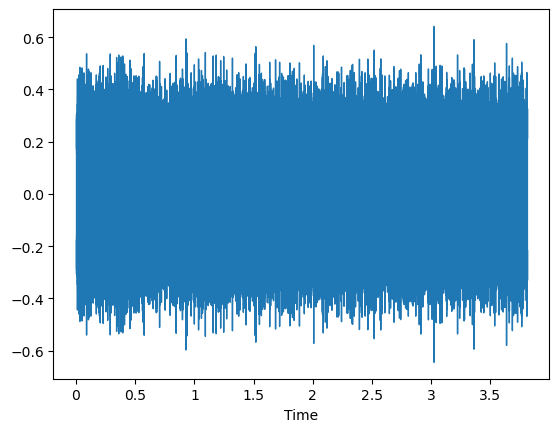

In [32]:
librosa.display.waveshow(noise_signal)

In [33]:
stft_noise= librosa.stft(noise_signal)    # Short-time Fourier transform
stft_noise_magnitude= np.abs(stft_noise)         # get magnitude
stft_noise_phase= np.angle(stft_noise) 

stft_noisy= librosa.stft(noisy_signal)    # Short-time Fourier transform
stft_noisy_magnitude= np.abs(stft_noisy)         # get magnitude
stft_noisy_phase= np.angle(stft_noisy) 

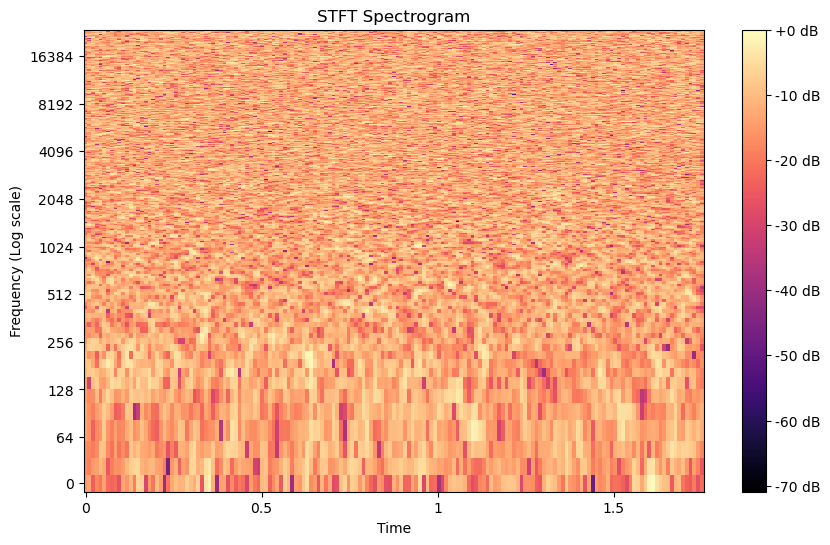

In [34]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_noise), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency (Log scale)')
plt.show()

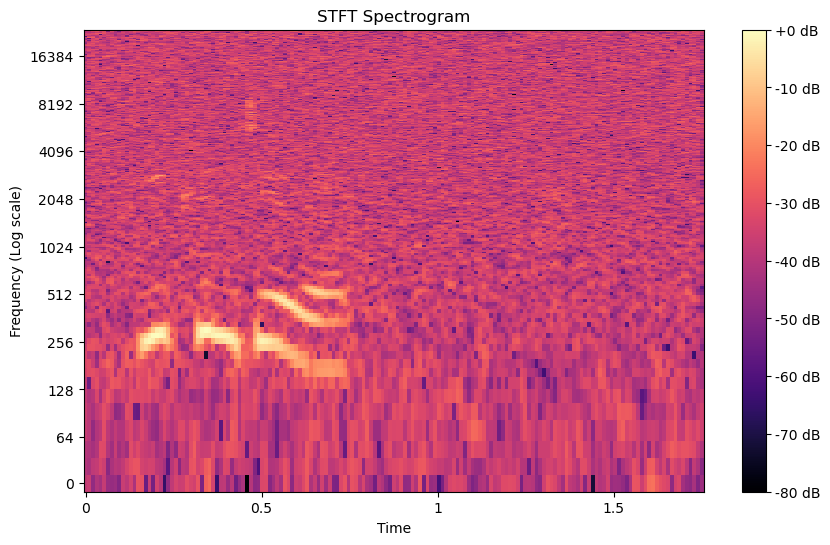

In [35]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_noisy), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency (Log scale)')
plt.show()

## References:

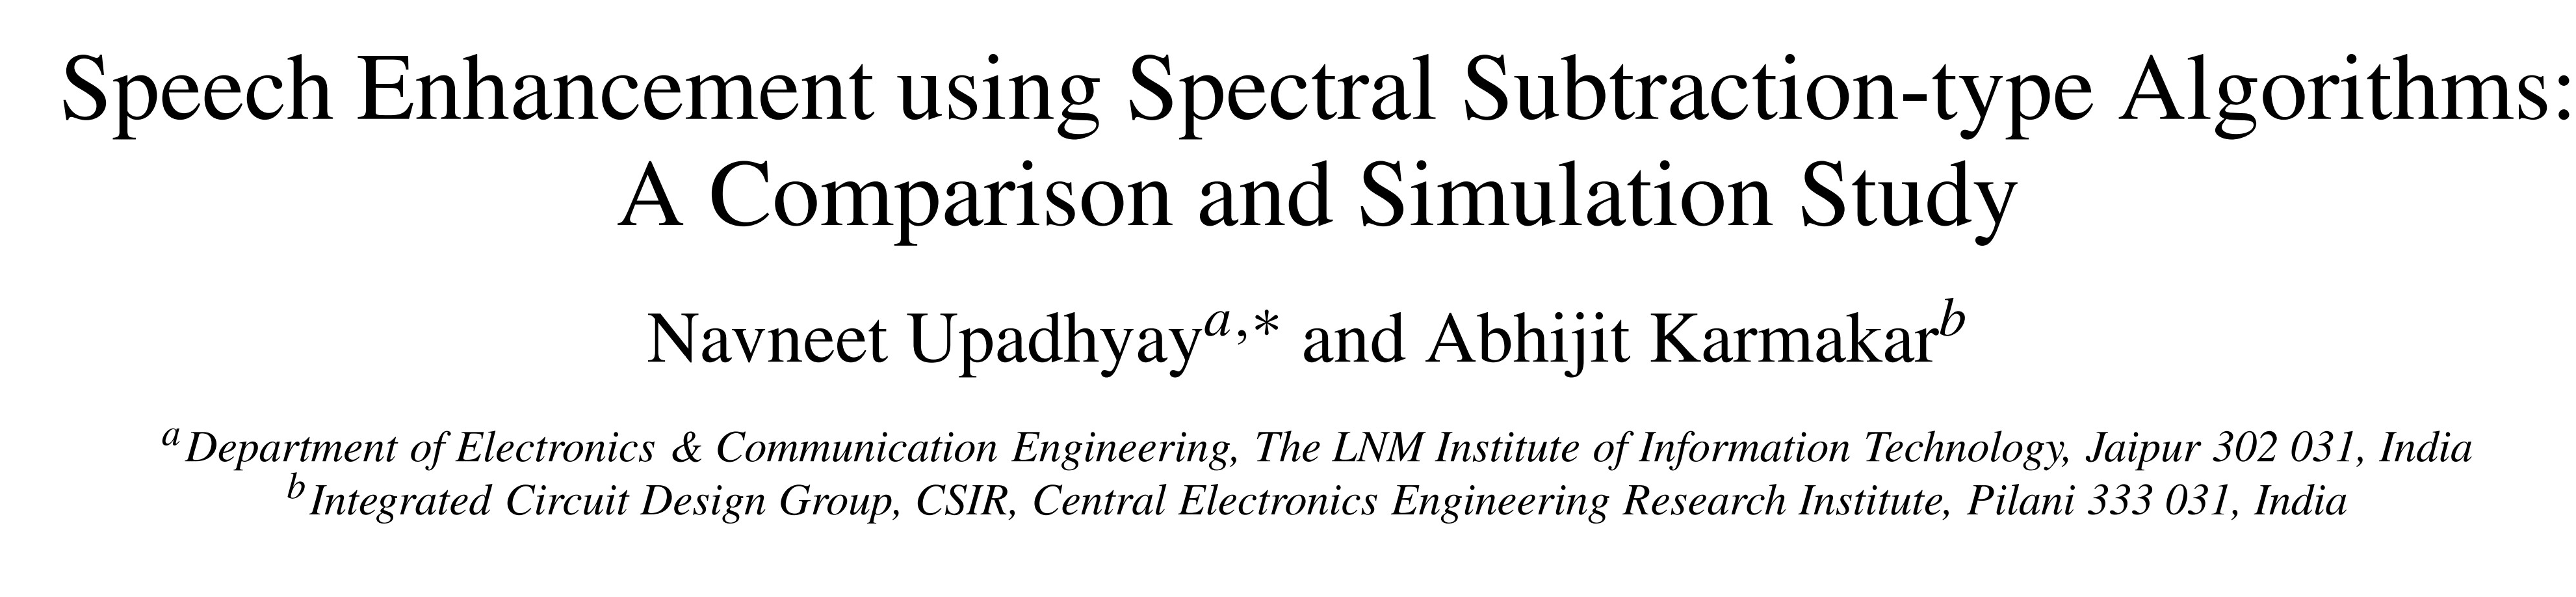

In [38]:
#Principle of spectral substraction
noise_estimate = np.mean(np.power(stft_noise_magnitude,2), axis=1)
sapower2= np.power(stft_noisy_magnitude,2) - noise_estimate.reshape(-1,1)  # reshape for broadcast to subtract
sa0= np.sqrt(np.abs(sapower2)) * np.exp(1.0j * stft_noisy_phase)  # apply phase information
cleaned_signal = librosa.istft(sa0)

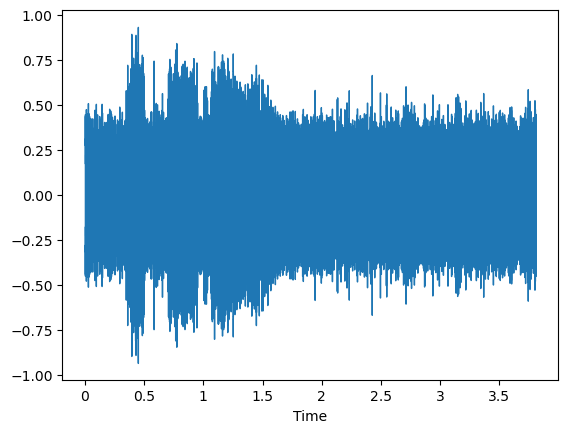

In [14]:
librosa.display.waveshow(cleaned_signal)

In [39]:
ipd.Audio(cleaned_signal, rate = sr)

### spectral over substraction


In [40]:
def spectral_subtraction(noisy_signal, noise_estimation, sr, alpha=1.0, beta=0.0000002):
    """
    Perform spectral subtraction to denoise the signal.
    
    Parameters:
    noisy_signal: numpy array
        The noisy input signal
    noise_estimation: numpy array
        The estimated noise signal
    sr: int
        Sample rate of the signal
    alpha: float
        Over-subtraction factor
    beta: float
        Spectral floor parameter
    
    Returns:
    numpy array
        The denoised signal
    """
    # Perform STFT (Short-time Fourier transform)
    n_fft = 2048
    hop_length = 512
    noisy_stft = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length)
    noise_stft = librosa.stft(noise_estimation, n_fft=n_fft, hop_length=hop_length)
    
    # Compute magnitude spectrums and power spectrums
    noisy_mag = np.abs(noisy_stft)
    noise_mag = np.abs(noise_stft)
    
    # Compute power spectrums
    noisy_power = noisy_mag ** 2
    noise_power = noise_mag ** 2
    
    # Spectral subtraction
    subtracted_power = noisy_power - alpha * noise_power
    subtracted_power = np.maximum(subtracted_power, beta * np.max(noisy_power))  # Apply flooring to avoid negative values
    
    # Convert power spectrum back to magnitude spectrum
    subtracted_mag = np.sqrt(np.abs(subtracted_power))
    
    # Reconstruct the signal using the original phase
    denoised_stft = subtracted_mag * np.exp(1j * np.angle(noisy_stft))
    
    # Perform inverse STFT
    denoised_signal = librosa.istft(denoised_stft, hop_length=hop_length)
    
    return denoised_signal

denoised_signal = spectral_subtraction(noisy_signal, noise_signal, sr)

# Save the denoised signal
ipd.Audio(denoised_signal, rate = sr)


### Multi band spectral substraction

In [45]:
def multi_band_spectral_subtraction(noisy_signal, noise_estimation, sr, alpha=1.0, beta=0.00000002, num_bands=4):
    """
    Perform multi-band spectral subtraction to denoise the signal.
    
    Parameters:
    noisy_signal: numpy array
        The noisy input signal
    noise_estimation: numpy array
        The estimated noise signal
    sr: int
        Sample rate of the signal
    alpha: float
        Over-subtraction factor
    beta: float
        Spectral floor parameter
    num_bands: int
        Number of frequency bands for processing
    
    Returns:
    numpy array
        The denoised signal
    """
    # Perform STFT (Short-time Fourier transform)
    n_fft = 2048
    hop_length = 512
    noisy_stft = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length)
    noise_stft = librosa.stft(noise_estimation, n_fft=n_fft, hop_length=hop_length)
    
    # Frequency bands
    freq_bins = noisy_stft.shape[0]
    bands = np.linspace(0, freq_bins, num_bands + 1, dtype=int)
    
    # Initialize the denoised spectrum
    denoised_stft = np.zeros_like(noisy_stft, dtype=complex)
    
    for i in range(num_bands):
        band_start = bands[i]
        band_end = bands[i + 1]
        
        # Compute magnitude spectrums and power spectrums for the current band
        noisy_mag = np.abs(noisy_stft[band_start:band_end, :])
        noise_mag = np.abs(noise_stft[band_start:band_end, :])
        
        noisy_power = noisy_mag ** 2
        noise_power = noise_mag ** 2
        
        # Spectral subtraction for the current band
        subtracted_power = noisy_power - alpha * noise_power
        subtracted_power = np.maximum(subtracted_power, beta * np.max(noisy_power))  # Apply flooring to avoid negative values
        
        # Convert power spectrum back to magnitude spectrum
        subtracted_mag = np.sqrt(subtracted_power)
        
        # Reconstruct the spectrum for the current band using the original phase
        denoised_stft[band_start:band_end, :] = subtracted_mag * np.exp(1j * np.angle(noisy_stft[band_start:band_end, :]))
    
    # Perform inverse STFT
    denoised_signal = librosa.istft(denoised_stft, hop_length=hop_length)
    
    return denoised_signal

denoised_signal = multi_band_spectral_subtraction(noisy_signal, noise_signal, sr)

ipd.Audio(denoised_signal, rate = sr)


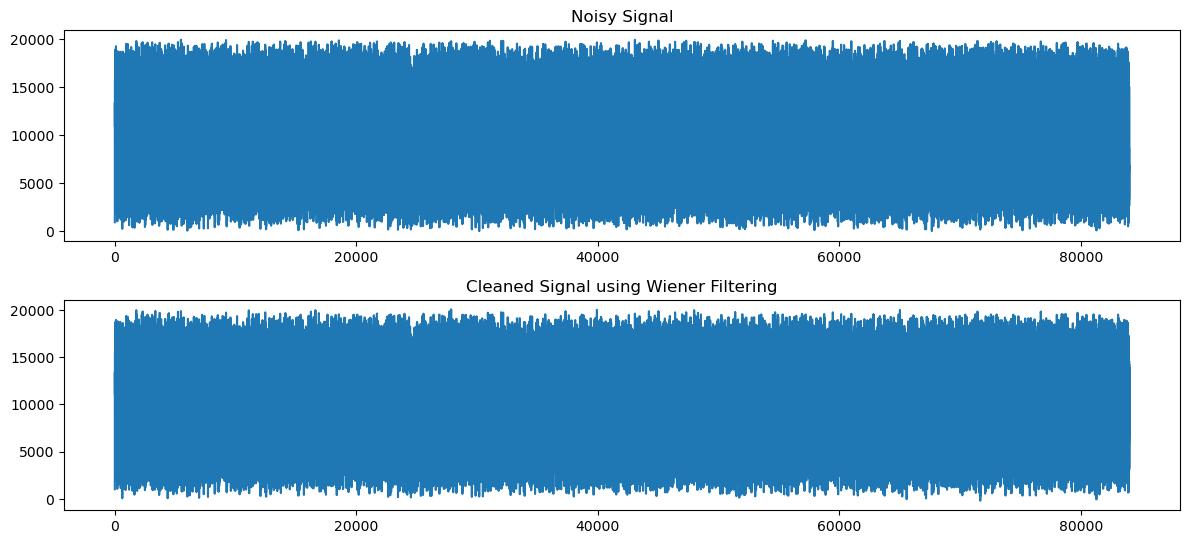

In [46]:
#Using Weiner filter 
#Lets inject some noise into it 

def noise(data):
    data = data + 10000 * np.random.uniform(size = data.shape[0])
    return data

noisy_signal = noise(noisy_signal)

# Convert to mono if stereo
if len(noisy_signal.shape) == 2:
    noisy_signal = noisy_signal.mean(axis=1)

# Perform FFT on the noisy signal
noisy_spectrum = scipy.fft.fft(noisy_signal)
frequencies = np.fft.fftfreq(len(noisy_signal))

# Estimate noise power spectrum from the first 1000 samples
noise_profile = noisy_signal[:1000]  # Assume first 1000 samples are noise
noise_spectrum = scipy.fft.fft(noise_profile)
noise_power = np.abs(noise_spectrum) ** 2

# Ensure the noise power spectrum matches the length of the signal power spectrum
noise_power = np.tile(noise_power, len(noisy_signal) // len(noise_power) + 1)[:len(noisy_signal)]

# Estimate the power spectrum of the noisy signal
signal_power = np.abs(noisy_spectrum) ** 2

# Estimate the clean signal power using Wiener filter formula
clean_power = signal_power - noise_power
clean_power = np.maximum(clean_power, 0)  # Ensure no negative values

# Wiener filter
H_wiener = clean_power / (clean_power + noise_power)
cleaned_spectrum = H_wiener * noisy_spectrum

# Reconstruct the cleaned signal using IFFT
cleaned_signal = scipy.fft.ifft(cleaned_spectrum).real

# Plot original, noisy, and cleaned signals
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(noisy_signal)
plt.title('Noisy Signal')
plt.subplot(3, 1, 2)
plt.plot(cleaned_signal)
plt.title('Cleaned Signal using Wiener Filtering')
plt.tight_layout()
plt.show()

# Optionally play the cleaned audio
ipd.Audio(cleaned_signal, rate=sr)


In [ ]:
### Spectral over substraction did it